# Sleep Stats

> Dustin Michels<br>
> August 2017, CC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

---

## I. Load & Examine the Data

In [2]:
# Use pandas.read_csv()
df = pd.read_csv('data.csv')

In [3]:
# This is what the first 10 rows look like.
df.head(10)

,id,tz,from,to,hours
0,1476573086157,Europe/Stockholm,16. 10. 2016 1:11,16. 10. 2016 8:38,7.46
1,1476658846218,Europe/Stockholm,17. 10. 2016 1:00,17. 10. 2016 5:30,4.50
2,1476679063263,Europe/Stockholm,17. 10. 2016 6:37,17. 10. 2016 8:33,1.93
3,1476742483671,Europe/Stockholm,18. 10. 2016 0:14,18. 10. 2016 7:28,7.24
4,1476827086302,Europe/Stockholm,18. 10. 2016 23:44,19. 10. 2016 5:31,5.78
5,1476848514023,Europe/Stockholm,19. 10. 2016 5:41,19. 10. 2016 5:54,0.22
6,1476999888240,Europe/Stockholm,20. 10. 2016 23:44,21. 10. 2016 5:38,5.90
7,1477021133168,Europe/Stockholm,21. 10. 2016 5:38,21. 10. 2016 7:28,1.82
8,1477101389293,Europe/Stockholm,22. 10. 2016 3:56,22. 10. 2016 11:11,7.26
9,1477177187404,Europe/Stockholm,23. 10. 2016 0:59,23. 10. 2016 8:01,7.02


---

## II. Make the `from` and `to` fields into datetime objects

The `From` and `To` fields hold awkwardly formatted strings, which are not very useful. They should be datetime objects, so we can perform opertaions on them.

In [4]:
# Use pandas.to_datetime(), indicating the day comes before the month
df['from'] = pd.to_datetime(df['from'], dayfirst=True)
df['to'] = pd.to_datetime(df['to'], dayfirst=True)

In [5]:
# Hey, works perfectly!
df.loc[0, 'from']

Timestamp('2016-10-16 01:11:00')

In [6]:
df.head()

,id,tz,from,to,hours
0,1476573086157,Europe/Stockholm,2016-10-16 01:11:00,2016-10-16 08:38:00,7.46
1,1476658846218,Europe/Stockholm,2016-10-17 01:00:00,2016-10-17 05:30:00,4.50
2,1476679063263,Europe/Stockholm,2016-10-17 06:37:00,2016-10-17 08:33:00,1.93
3,1476742483671,Europe/Stockholm,2016-10-18 00:14:00,2016-10-18 07:28:00,7.24
4,1476827086302,Europe/Stockholm,2016-10-18 23:44:00,2016-10-19 05:31:00,5.78


---
## III.  Consolidate Fragmented Entries

I notice some nights are broken into multiple entries. For example, in rows 2-3 above, I logged sleep from `1:00am-5:30am`, then again from `6:37am-8:33am.` I want to sum these durations together before I try calculating something like 'mean hours of sleep per night.'

In [7]:
# The raw mean:
df.hours.mean()

6.7070044052863445

In [8]:
# 6.7 hours / night is probably an underestimate,
# due to nights broken into multiple entries.

### First, add  `date` column

First, add a 'date' field, which best reflects the overall date for the entry. Since I might fall asleep before or after midnight (ie, the `from` field is inconsistant), I think sleep date is best given by 'wake up date - 1 day'

In [9]:
# Use 'apply', providing pandas.datetime.date() as the function,
# to transform the to field ino the date column.
# Use 'pandas.DateOffset()' to subtract a day

df['date'] = df.to.apply(pd.datetime.date)
df['date'] = df['date'] - pd.DateOffset()

In [10]:
df.head(10)

,id,tz,from,to,hours,date
0,1476573086157,Europe/Stockholm,2016-10-16 01:11:00,2016-10-16 08:38:00,7.46,2016-10-15
1,1476658846218,Europe/Stockholm,2016-10-17 01:00:00,2016-10-17 05:30:00,4.50,2016-10-16
2,1476679063263,Europe/Stockholm,2016-10-17 06:37:00,2016-10-17 08:33:00,1.93,2016-10-16
3,1476742483671,Europe/Stockholm,2016-10-18 00:14:00,2016-10-18 07:28:00,7.24,2016-10-17
4,1476827086302,Europe/Stockholm,2016-10-18 23:44:00,2016-10-19 05:31:00,5.78,2016-10-18
5,1476848514023,Europe/Stockholm,2016-10-19 05:41:00,2016-10-19 05:54:00,0.22,2016-10-18
6,1476999888240,Europe/Stockholm,2016-10-20 23:44:00,2016-10-21 05:38:00,5.90,2016-10-20
7,1477021133168,Europe/Stockholm,2016-10-21 05:38:00,2016-10-21 07:28:00,1.82,2016-10-20
8,1477101389293,Europe/Stockholm,2016-10-22 03:56:00,2016-10-22 11:11:00,7.26,2016-10-21
9,1477177187404,Europe/Stockholm,2016-10-23 00:59:00,2016-10-23 08:01:00,7.02,2016-10-22


### Next, group by `date` and deal with repeats

In [11]:
# Next, we want to group entries by date.
g = df.groupby('date')

In [12]:
# Some nights have entries, while others have one.
g.count().head(10)

,id,tz,from,to,hours
date,,,,,
2016-10-15,1,1,1,1,1
2016-10-16,2,2,2,2,2
2016-10-17,1,1,1,1,1
2016-10-18,2,2,2,2,2
2016-10-20,2,2,2,2,2
2016-10-21,1,1,1,1,1
2016-10-22,1,1,1,1,1
2016-10-23,1,1,1,1,1
2016-10-24,1,1,1,1,1


In [13]:
# To squash these entries into a one night,
# we define what to do with each column.

df = g.aggregate({
    'tz':'first',
    'from':'first',
    'to':'last',
    'hours':'sum'
})

Now, `to` reflects initial fall asleep time, and `from` reflects ultimate wake up time.<br>
*NOTE:* There may or may not be a gap in between these times. Thus, the duration between `from` and `to` may have diverged from the actual # hours, given by the `hours` column.

In [14]:
df.head(10)

,tz,from,to,hours
date,,,,
2016-10-15,Europe/Stockholm,2016-10-16 01:11:00,2016-10-16 08:38:00,7.46
2016-10-16,Europe/Stockholm,2016-10-17 01:00:00,2016-10-17 08:33:00,6.43
2016-10-17,Europe/Stockholm,2016-10-18 00:14:00,2016-10-18 07:28:00,7.24
2016-10-18,Europe/Stockholm,2016-10-18 23:44:00,2016-10-19 05:54:00,6.00
2016-10-20,Europe/Stockholm,2016-10-20 23:44:00,2016-10-21 07:28:00,7.72
2016-10-21,Europe/Stockholm,2016-10-22 03:56:00,2016-10-22 11:11:00,7.26
2016-10-22,Europe/Stockholm,2016-10-23 00:59:00,2016-10-23 08:01:00,7.02
2016-10-23,Europe/Stockholm,2016-10-24 01:08:00,2016-10-24 06:54:00,5.77
2016-10-24,Europe/Stockholm,2016-10-25 03:03:00,2016-10-25 07:12:00,4.14


## IV. Analyze by weekday

In [15]:
df['weekday'] = df.index.dayofweek
df['weekday'] = df['weekday'].astype('category')

In [17]:
# Look at data, by weekday
# Note: Monday == 0 ... Sunday == 6

df.groupby('weekday')['hours'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,31.0,6.928387,1.335500,2.73,6.285,7.160,7.6750,9.15
1,33.0,6.633636,1.315971,2.26,6.000,6.640,7.4500,8.68
2,28.0,7.898571,1.513560,4.47,7.060,7.765,8.6675,11.75
3,28.0,7.386071,2.949685,2.88,6.465,7.260,8.0950,19.50
4,26.0,8.795000,2.251057,3.60,7.395,8.685,9.8125,16.80
5,25.0,7.693200,1.000232,6.04,7.010,7.250,8.3800,10.01
6,36.0,6.661944,1.616647,0.42,5.930,6.685,7.4775,10.21


### Outlier alert!

At this point I realize there might be some outliers! A min like 2.73 hours seems very possible, unfortunately, but a max like `19.50` hours and even `16.80` hours does not...

---

## V. Remove Outliers

I'll try using the sigma clipping method outlined in Jake VanderPlas' *Python Data Science Handbook*


In [19]:
# Sigma Clip

quartiles = np.percentile(df['hours'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

df_clipped = df.query('(hours > @mu - 5 * @sig) & (hours < @mu + 5 * @sig)')

In [21]:
# Describe the new data

df_clipped.groupby('weekday')['hours'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,31.0,6.928387,1.335500,2.73,6.285,7.160,7.6750,9.15
1,33.0,6.633636,1.315971,2.26,6.000,6.640,7.4500,8.68
2,28.0,7.898571,1.513560,4.47,7.060,7.765,8.6675,11.75
3,27.0,6.937407,1.783848,2.88,6.380,7.030,8.0400,9.92
4,25.0,8.474800,1.581642,3.60,7.360,8.650,9.7000,11.61
5,25.0,7.693200,1.000232,6.04,7.010,7.250,8.3800,10.01
6,35.0,6.840286,1.229528,4.39,6.185,6.730,7.5450,10.21


Hey, that's better! The stats spoke for themselves, and the sigma clip correctly removed the major outliers on the top (19.5 and 16.8) while leaving the lower values, which I suspected were not actually that unusual for me.

In [22]:
## IV. Analyze by weekday

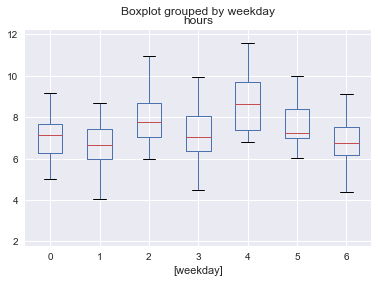

In [23]:
%matplotlib inline
# col = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df_clipped.boxplot(by='weekday')

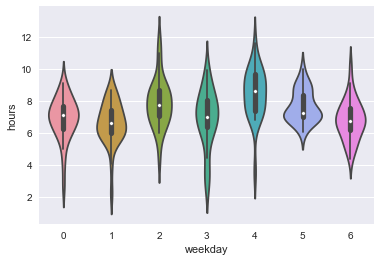

In [25]:
sns.violinplot(x=df_clipped.weekday, y=df_clipped.hours)

School vs. Home, by weekday